## Pendulum: One-step Method

In [1]:
import sys
#sys.path.append('/Users/josorior/Documents/UW/research/keql/KEQL/source')
#sys.path.append('/Users/yasaminjalalian/Repos/KEQL/source')
sys.path.append('/home/juanfelipe/Desktop/research/keql/source')

In [2]:
import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [3]:
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.kernel_ridge import KernelRidge
from parameter_learning import *
from plotlib import *
from models import * 
from kernels import *
from data_loader import *
from loss import *
from utils import *

import jax.numpy as jnp
from jax import grad, jit
from jax.scipy.optimize import minimize
from jax.config import config; 
config.update("jax_enable_x64", True)

from functools import partial # for jit to make codes faster

In [4]:
model = 'pendulum'

In [ ]:
# Import values from 2-step
two_step_dict = np.load('data/two_step_dict.npy', allow_pickle=True)
two_step_dict = two_step_dict.item()

### Cost function

Compute `Kphiphi` and its corresponding regularizing matrix `R`

In [5]:
# Create Kphiphi
X = x_train_all.flatten()
sigma_K = jnp.array(np.load('data/optim_sgm.npy'))
Kphiphis = [Kphiphi_assembly( X[i*e:(i+1)*e] , k = 'Gaussian', k_param = sigma_K[i]) for i in range(3)]

In [6]:
Rs = [jnp.diag(jnp.diag(Kphiphis[i])) for i in range(3)]

In [7]:
optim_sgm_P = jnp.array(np.load('data/optim_sgm_P.npy'))
rkhs_u = jnp.array(np.load('data/rkhs_u.npy'))
rkhs_P = jnp.array(np.load('data/rkhs_P.npy'))
nugget_Gamma = jnp.array(np.load('data/nugget_Gamma.npy'))

Create objective function `L`

In [8]:
def L(Z, X, U, f, Kphiphis, Rs, optim_sgm_P, rkhs_u, rkhs_P, nugget_Gamma, lmbd):
    """Cost function for one step method.
    
    Args:
        Z: Vector of optimization variables in the cost function. 2*m*N
        X: List of mN points of dimension d.
        U: List of mN values of functions u^(1),...u^(N).
        f: List of mN values of functions u^(1),...u^(N).
        R: Matrix that regularizes Kphiphi
        vars: Dictionary with values from 2-step.
    Returns:
        scalar: a cost of this solution.    
    """ 
    # Re-shape Z into a matrix
    Z = Z.reshape(2,9).T

    ### First term

    # Build S_N
    S1 = jnp.vstack([X,U]).T
    S = jnp.hstack([S1,Z])

    # Scaling S_N
    scaler_s_train = MinMaxScaler()
    S = scaler_s_train.fit_transform(S)
    
    # Gamma(S_N,S_N)
    #sigma_Gamma = 0.8152747082066607 # From 2-step 
    sigma_Gamma = optim_sgm_P
    Gamma = K(Gaussian, S, S, sigma_Gamma)
    #alpha_Gamma = 1e-7 # From 2-step
    alpha_Gamma = nugget_Gamma
    Gamma = Gamma + alpha_Gamma*jnp.eye(jnp.size(Gamma,0)) 
    #print("cond(Gamma) = ", jnp.linalg.cond(Gamma)) # Condition number of Gamma

    # (Gamma(S_N,S_N) + alpha_Gamma*I)^-1 * f
    b = jnp.linalg.solve(Gamma,f)

    # First term
    #rkhs_P = 4038.8546192430285 # From 2-step
    L1 = jnp.dot(f.T , b) / rkhs_P
    #print("L1(Z_warm) = ", L1)


    ### Second term

    L2 = 0.

    alpha_K = 1e-6 # Nugget 
    Kphiphis = [Kphiphis[i] + alpha_K*Rs[i] for i in range(3)] 
    #print("cond(Kphiphis) = ", jnp.linalg.cond(Kphiphis)) # Condition number

    #rkhss = [1.1833129190245972, 10.115269194432372, 136.2124679543351]
    ZZ = jnp.hstack((U.reshape(-1,1),Z))
    for i in range(3):
        Z_i = jnp.reshape(ZZ[e*i:e*(i+1),:].T,(e*3,1)) # DOUBLE CHECK THE ORDER HERE
        #print('Z_{}'.format(i),Z_i) 
        c = jnp.linalg.solve(Kphiphis[i],Z_i) 
        L2 += jnp.reshape(jnp.dot(Z_i.T , c),())/rkhs_u[i] # NORMALIZATION MIGHT NOT BE NEEDED HERE IN THE 1.5 STEP METHOD
        #print("L2_{} = ".format(i+1),jnp.reshape(jnp.dot(Z_i.T , c),())/rkhss[i])
    # Compute the total loss per epoch - It's going down !
    # Compute the loss per function u epoch  
    # Compute the total loss normalized per epoch
    # Compute the loss per function u normalized per epoch

    #print("L2(Z_warm) = ",L2)

    return L1 + lmbd*L2 # Return loss.

#### Training data and warm up

Training data

In [9]:
# First column in Gamma(S_N,S_N)
X = x_train_all.flatten() # N*m * 1

# Second column in Gamma(S_N,S_N)
U = u_train.T.reshape(e*m,) # N*m * 1

# f(X_N)
f = f_Train(model)

Initial guess: `Z_warm`

In [10]:
# Load gradients from 2-step
u_x_pred_train  = np.load('data/u_x_pred_train.npy')
u_xx_pred_train = np.load('data/u_xx_pred_train.npy')
# Build Z_warm
Z_warm = np.hstack([u_x_pred_train.T.reshape(e*m,1),u_xx_pred_train.T.reshape(e*m,1)])
Z_warm = Z_warm.T.flatten()

In [11]:
L(Z_warm, X, U, f, Kphiphis, Rs, optim_sgm_P, rkhs_u, rkhs_P, nugget_Gamma, lmbd = 1/3)

Array(1.9999881, dtype=float64)

In [12]:
lmbd_min = 1/3 

#### LBFGS

In [13]:
# Load the warm-up
Z = np.copy(Z_warm)

In [14]:
result = minimize(L, Z, args=(X, U, f, Kphiphis, Rs, optim_sgm_P, rkhs_u, rkhs_P, nugget_Gamma, 1/3), method= 'BFGS')

In [15]:
Z = result.x.reshape(2,9).T

#### Evaluation of `Z`

In [16]:
# Load true gradients from 2-step
u_x_train = np.load('data/u_x_train.npy')
u_xx_train = np.load('data/u_xx_train.npy')
# Build true Z
Z_true = np.hstack([u_x_train.T.reshape(e*m,1),u_xx_train.T.reshape(e*m,1)])

> One-step Method vs Truth

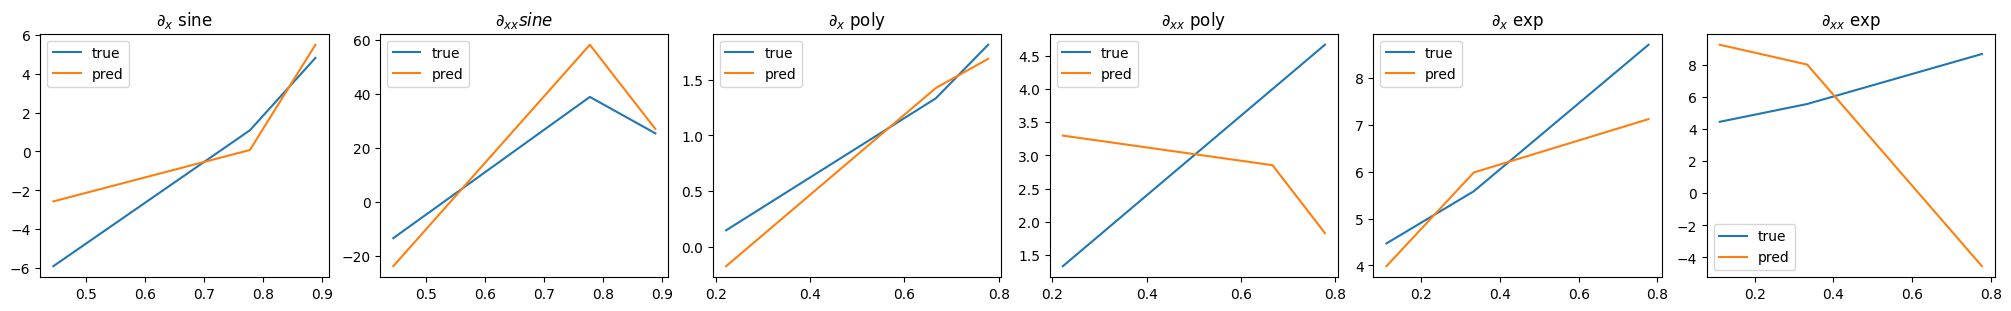

In [17]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows = 1, ncols=6, figsize = (20,3),constrained_layout=True)
ax1.set_title(r'$\partial_x$ sine')
ax1.plot(x_train[0:e],Z_true[0:e,0],label ='true')
ax1.plot(x_train[0:e],Z[0:e,0],label ='pred')
ax1.legend()
ax2.set_title(r'$\partial_{xx} sine$')
ax2.plot(x_train[0:e],Z_true[0:e,1],label ='true')
ax2.plot(x_train[0:e],Z[0:e,1],label ='pred')
ax2.legend()
ax3.set_title(r'$\partial_x$ poly')
ax3.plot(x_train[e:2*e],Z_true[e:2*e,0],label ='true')
ax3.plot(x_train[e:2*e],Z[e:2*e,0],label ='pred')
ax3.legend()
ax4.set_title(r'$\partial_{xx}$ poly')
ax4.plot(x_train[e:2*e],Z_true[e:2*e,1],label ='true')
ax4.plot(x_train[e:2*e],Z[e:2*e,1],label ='pred')
ax4.legend()
ax5.set_title(r'$\partial_x$ exp')
ax5.plot(x_train[2*e:3*e],Z_true[2*e:3*e,0],label ='true')
ax5.plot(x_train[2*e:3*e],Z[2*e:3*e,0],label ='pred')
ax5.legend()
ax6.set_title(r'$\partial_{xx}$ exp')
ax6.plot(x_train[2*e:3*e],Z_true[2*e:3*e,1],label ='true')
ax6.plot(x_train[2*e:3*e],Z[2*e:3*e,1],label ='pred')
ax6.legend()
plt.show()

> Two-step Method vs Truth

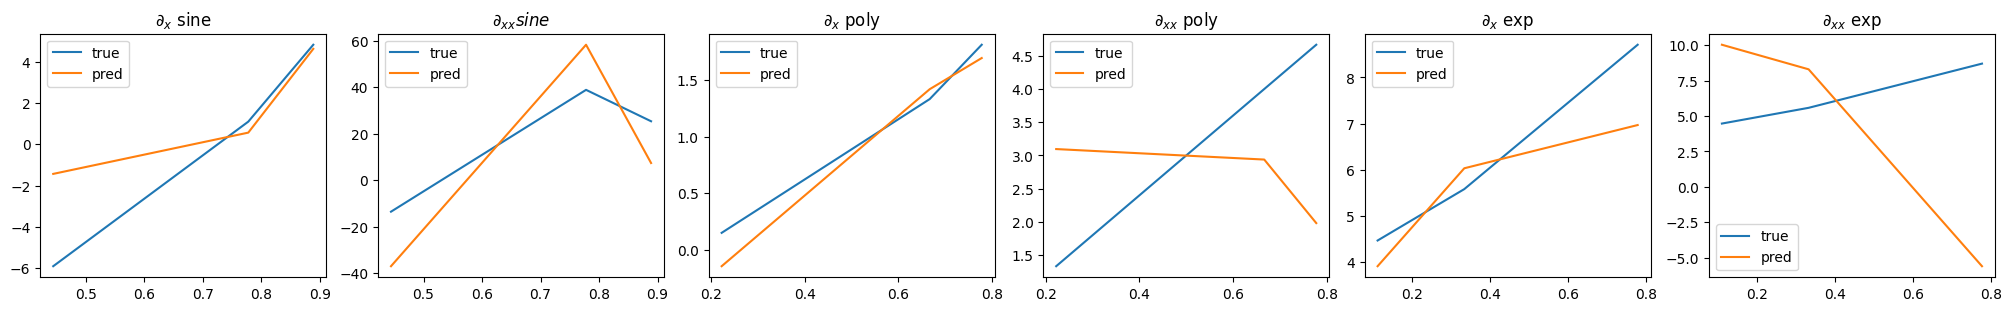

In [36]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows = 1, ncols=6, figsize = (20,3),constrained_layout=True)
ax1.set_title(r'$\partial_x$ sine')
ax1.plot(x_train[0:e],Z_true[0:e,0],label ='true')
ax1.plot(x_train[0:e],Z_warm[0:e,0],label ='pred')
ax1.legend()
ax2.set_title(r'$\partial_{xx} sine$')
ax2.plot(x_train[0:e],Z_true[0:e,1],label ='true')
ax2.plot(x_train[0:e],Z_warm[0:e,1],label ='pred')
ax2.legend()
ax3.set_title(r'$\partial_x$ poly')
ax3.plot(x_train[e:2*e],Z_true[e:2*e,0],label ='true')
ax3.plot(x_train[e:2*e],Z_warm[e:2*e,0],label ='pred')
ax3.legend()
ax4.set_title(r'$\partial_{xx}$ poly')
ax4.plot(x_train[e:2*e],Z_true[e:2*e,1],label ='true')
ax4.plot(x_train[e:2*e],Z_warm[e:2*e,1],label ='pred')
ax4.legend()
ax5.set_title(r'$\partial_x$ exp')
ax5.plot(x_train[2*e:3*e],Z_true[2*e:3*e,0],label ='true')
ax5.plot(x_train[2*e:3*e],Z_warm[2*e:3*e,0],label ='pred')
ax5.legend()
ax6.set_title(r'$\partial_{xx}$ exp')
ax6.plot(x_train[2*e:3*e],Z_true[2*e:3*e,1],label ='true')
ax6.plot(x_train[2*e:3*e],Z_warm[2*e:3*e,1],label ='pred')
ax6.legend()
plt.show()

2. Get all the information as we optimize, e.g., progress of P^*.
3. Code the 1.5 step method.
4. We should include the constrain of enforcing the PDE for each u_i at the remaining u_i's.

#### Predictions of P

Recall on the Representer formula

$$
P^*(\cdot) = \Gamma(\cdot,S_N) \Gamma(S_N,S_N)^{-1} f(X_N)
$$

In [ ]:
# Build S_N
S1 = jnp.vstack([X,U]).T
S = jnp.hstack([S1,Z])